In [27]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [28]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/datosEmpleo.xlsx?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_excel(url,index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [29]:
  Resultados_columnas = ['Modelo', 'Configuración', 'RMSE', 'Coef R2']
  Resultados = pd.DataFrame(columns=Resultados_columnas)

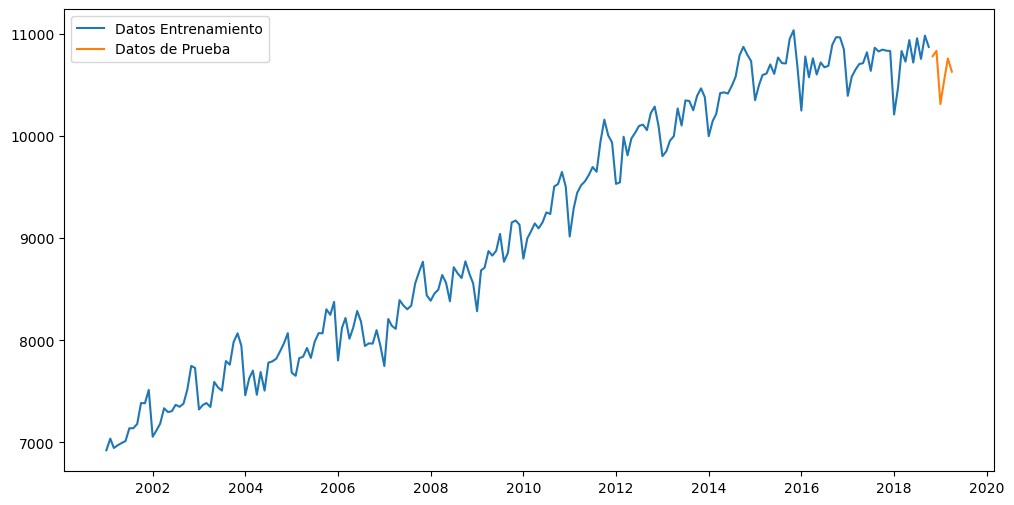

In [30]:
train_len = 214
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

MODELOS

**DATOS**

**Media Movil**

In [31]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [32]:
def calcular_media_movil_actual(train_td, order):
  ma= train_td.rolling(orden,min_periods=2).mean()

  ma_f= fore_ma(train_td,orden,6)
  rmse_ma = np.sqrt(mean_squared_error(test_td,ma_f ))
  r2_ma = r2_score(test_td, ma_f)
  #print("RMSE:", rmse_ma)
  #print("Coef R2:", r2_ma)
  return ma,orden,rmse_ma,r2_ma,ma_f

def calcular_media_movil(train_td, order):
  ma= train_td.shift().rolling(2,min_periods=2).mean()
  ma_f= fore_ma(train_td,orden,6)
  rmse_ma = np.sqrt(mean_squared_error(test_td,ma_f ))
  r2_ma = r2_score(test_td, ma_f)
  #print("RMSE:", rmse_ma)
  #print("Coef R2:", r2_ma)
  return ma,orden,rmse_ma,r2_ma,ma_f

In [33]:
# Suavizacion Media Movil (ordenes desde 2 a 6)
## Considerando dato actual
#ordenes = [2, 3, 4, 5, 6,7,8,9]
ordenes = [5,15,45,60,65,68,70,80]

for orden in ordenes:
  ma_series, orden_, rmse_ma_, r2_ma_,ma_f_ = calcular_media_movil_actual(train_td, orden)
  Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)

## Sin considerar dato actual
for orden in ordenes:
  ma_series, orden_, rmse_ma_, r2_ma_,ma_f_ = calcular_media_movil(train_td, orden)
  Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil (Sin)', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)


C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\1699220914.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)
C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\1699220914.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)
C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\1699220914.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil'

**Suavizacion Exponencial Simple**



In [34]:
#combinaciones Exp Simple
combinaciones = [("add"), ("mul")]

In [35]:
for error in combinaciones:
  ets_model = ETSModel(endog=train_td["Ocupados"],error=error)
  ets_result = ets_model.fit()

  point_forecast=ets_result.forecast(6)

  ci = ets_result.get_prediction(start = point_forecast.index[0],
                                  end = point_forecast.index[-1])

  conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
  limits = ci.predicted_mean


  preds = pd.concat([limits, conf_forecast], axis = 1)
  preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
  rmse_es = np.sqrt(mean_squared_error(test_td,preds['Point_forecast']))
  #print(rmse_es)
  r2_es = r2_score(test_td, point_forecast)
  #print("Coef R2:", r2_es)
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Simple', 'Configuración': error, 'RMSE': rmse_es, 'Coef R2': r2_es}, ignore_index=True)

C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\406612147.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Simple', 'Configuración': error, 'RMSE': rmse_es, 'Coef R2': r2_es}, ignore_index=True)
C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\406612147.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'

Suavizacion Exponencial Lineal **(Holt)**



In [36]:
#combinaciones para HOLT
combinaciones = [("add", "add"), ("add", "mul"),("mul", "add"),("mul", "mul"),("add", None),("mul", None)]

In [37]:
for error,trend in combinaciones:
  ets_model = ETSModel(endog=train_td["Ocupados"],error=error,trend=trend)
  ets_result = ets_model.fit()

  point_forecast=ets_result.forecast(6)

  ci = ets_result.get_prediction(start = point_forecast.index[0],
                                  end = point_forecast.index[-1])

  conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
  limits = ci.predicted_mean
  NTrend,NSeasonal = "",""
  match trend:
    case None:
      NTrend = 'None'
    case _:
      NTrend = trend

  preds_holt = pd.concat([limits, conf_forecast], axis = 1)
  preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
  rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
  #print(rmse_holt)
  r2_holt = r2_score(test_td, point_forecast)
  #print("Coef R2:", r2_holt)
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal (Holt)', 'Configuración': error+'/'+NTrend, 'RMSE': rmse_holt, 'Coef R2': r2_holt}, ignore_index=True)


C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\349110467.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal (Holt)', 'Configuración': error+'/'+NTrend, 'RMSE': rmse_holt, 'Coef R2': r2_holt}, ignore_index=True)
C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\349110467.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados 

**Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [38]:
combinaciones = [("add", "add", "add"), ("add", "add", "mul"), ("add", "mul", "add"), ("add", "mul", "mul"),
                  ("mul", "mul", "mul"), ("mul", "add", "add"), ("mul", "add", "mul"), ("mul", "mul", "add")
                 ,('add', 'add', None), ('add', None, 'add'), ('add', None, None),
                  ('add', 'mul', None), ('add', None, 'mul'),
                  ('mul', 'mul', None), ('mul', None, 'add'), ('mul', None, None),
                  ('mul', 'add', None), ('mul', None, 'mul')]


In [39]:
for error,trend,seasonal in combinaciones:

  ets_model = ETSModel(endog=train_td["Ocupados"],error=error,trend=trend,seasonal=seasonal )
  ets_result = ets_model.fit()

  point_forecast=ets_result.forecast(6)

  ci = ets_result.get_prediction(start = point_forecast.index[0],
                                  end = point_forecast.index[-1])

  conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
  limits = ci.predicted_mean
  NTrend,NSeasonal = "",""
  match trend:
    case None:
      NTrend = 'None'
    case _:
      NTrend = trend
  match seasonal:
      case None:
        NSeasonal = 'None'
      case _:
        NSeasonal = seasonal

  preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
  preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
  rmse_hw_add = np.sqrt(mean_squared_error(test_td,preds_hw_add['Point_forecast']))
  #print("RMSE: ",rmse_hw_add,"PARAMETROS:",error,trend,seasonal)
  r2_hw = r2_score(test_td, point_forecast)
  #print("Coef R2:", r2_hw)
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal de Winters (Holt-Winters)', 'Configuración': error+'/'+NTrend+'/'+NSeasonal, 'RMSE': rmse_hw_add, 'Coef R2': r2_hw}, ignore_index=True)


C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\2466773278.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal de Winters (Holt-Winters)', 'Configuración': error+'/'+NTrend+'/'+NSeasonal, 'RMSE': rmse_hw_add, 'Coef R2': r2_hw}, ignore_index=True)
C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\2466773278.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\2466773278.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal de Winters (Holt-Winters)', 'Configuración': error+'/'+NTrend+'/'+NSeasonal, 'RMSE': rmse_hw_add, 'Coef R2': r2_hw}, ignore_index=True)
C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\CARLOS\AppData\Local\Temp\ipykernel_19064\2466773278.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Suavizacion Exp Lineal de Winters (Holt-Winters)', 'Configuración': error+'/'+NTrend+'/'+NSeasonal, 'RMSE': rmse_hw_add, 'Coef R2': r2_hw}, 

In [40]:
Resultados

,Modelo,Configuración,RMSE,Coef R2
0,Suavizacion Media Movil,Orden 5,291.016063,-1.735284
1,Suavizacion Media Movil,Orden 15,212.448217,-0.457722
2,Suavizacion Media Movil,Orden 45,199.586243,-0.286559
3,Suavizacion Media Movil,Orden 60,180.873036,-0.056614
4,Suavizacion Media Movil,Orden 65,178.151804,-0.025059
5,Suavizacion Media Movil,Orden 68,180.316474,-0.050121
6,Suavizacion Media Movil,Orden 70,183.400536,-0.086350
7,Suavizacion Media Movil,Orden 80,207.414178,-0.389458
8,Suavizacion Media Movil (Sin),Orden 5,291.016063,-1.735284
9,Suavizacion Media Movil (Sin),Orden 15,212.448217,-0.457722


In [41]:
Resultados[24:]

,Modelo,Configuración,RMSE,Coef R2
24,Suavizacion Exp Lineal de Winters (Holt-Winters),add/add/add,163.614976,0.135401
25,Suavizacion Exp Lineal de Winters (Holt-Winters),add/add/mul,156.414737,0.209824
26,Suavizacion Exp Lineal de Winters (Holt-Winters),add/mul/add,169.239713,0.074933
27,Suavizacion Exp Lineal de Winters (Holt-Winters),add/mul/mul,154.837076,0.225684
28,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/mul/mul,160.577047,0.167210
29,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/add/add,166.384484,0.105883
30,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/add/mul,162.249785,0.149769
31,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/mul/add,169.111266,0.076337
32,Suavizacion Exp Lineal de Winters (Holt-Winters),add/add/None,370.157974,-3.425300
33,Suavizacion Exp Lineal de Winters (Holt-Winters),add/None/add,74.994180,0.818355


In [42]:
Resultados[:24]

,Modelo,Configuración,RMSE,Coef R2
0,Suavizacion Media Movil,Orden 5,291.016063,-1.735284
1,Suavizacion Media Movil,Orden 15,212.448217,-0.457722
2,Suavizacion Media Movil,Orden 45,199.586243,-0.286559
3,Suavizacion Media Movil,Orden 60,180.873036,-0.056614
4,Suavizacion Media Movil,Orden 65,178.151804,-0.025059
5,Suavizacion Media Movil,Orden 68,180.316474,-0.050121
6,Suavizacion Media Movil,Orden 70,183.400536,-0.086350
7,Suavizacion Media Movil,Orden 80,207.414178,-0.389458
8,Suavizacion Media Movil (Sin),Orden 5,291.016063,-1.735284
9,Suavizacion Media Movil (Sin),Orden 15,212.448217,-0.457722


In [43]:
Resultados.to_csv('resultados_t1_modelo.csv', index=False)

**FIGURAS** [Prediccion con datos de train]

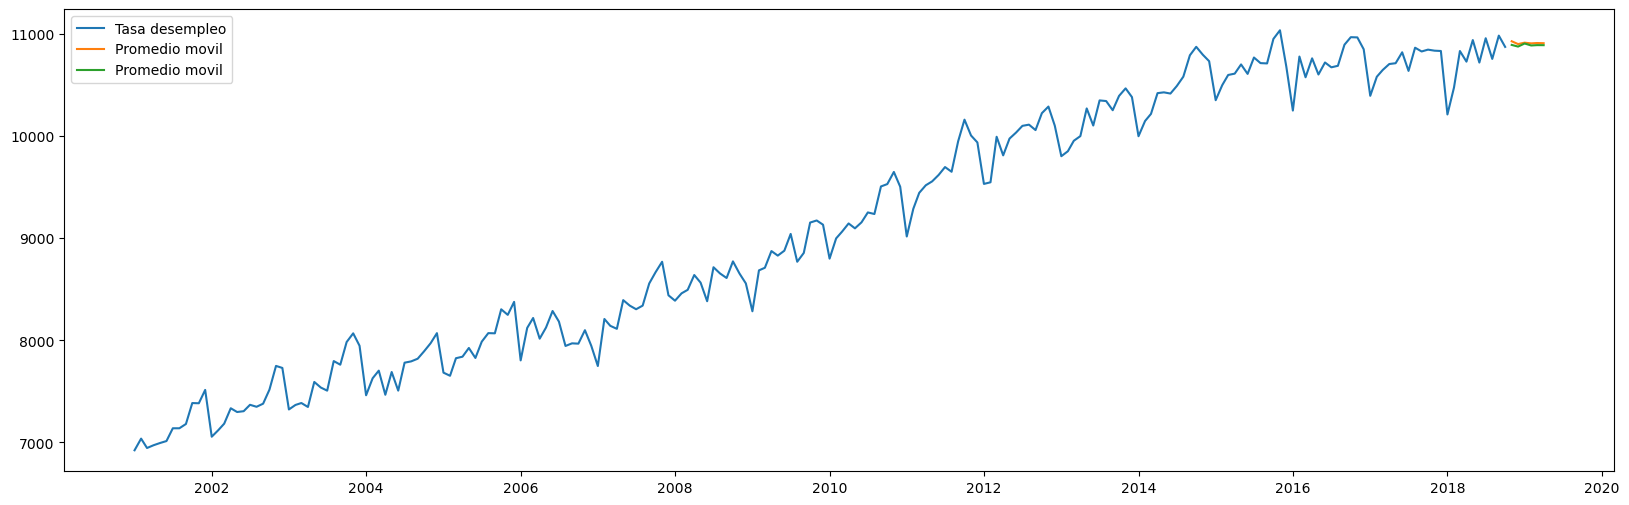

In [44]:
# Suavizacion Media Movil (ordenes desde 2 a 5)
## Sin considerar dato actual
ordenes = [2, 3, 4, 5]
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa desempleo")
for orden in ordenes:
  ma_series, orden_, rmse_ma_, r2_ma_,ma_f_ = calcular_media_movil(train_td, orden)
  #Resultados = Resultados.append({'Modelo': 'Suavizacion Media Movil', 'Configuración': f'Orden {orden_}', 'RMSE': rmse_ma_, 'Coef R2': r2_ma_}, ignore_index=True)
  if orden == 2 or orden == 4:
    plt.plot(ma_f_,label="Promedio movil")
plt.legend()
plt.show()

C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10890.815857  10535.182690  11246.449023
2018-12-01    10890.815857  10469.673442  11311.958272
2019-01-01    10890.815857  10413.063915  11368.567799
2019-02-01    10890.815857  10362.485560  11419.146154
2019-03-01    10890.815857  10316.343153  11465.288560
2019-04-01    10890.815857  10273.640945  11507.990769


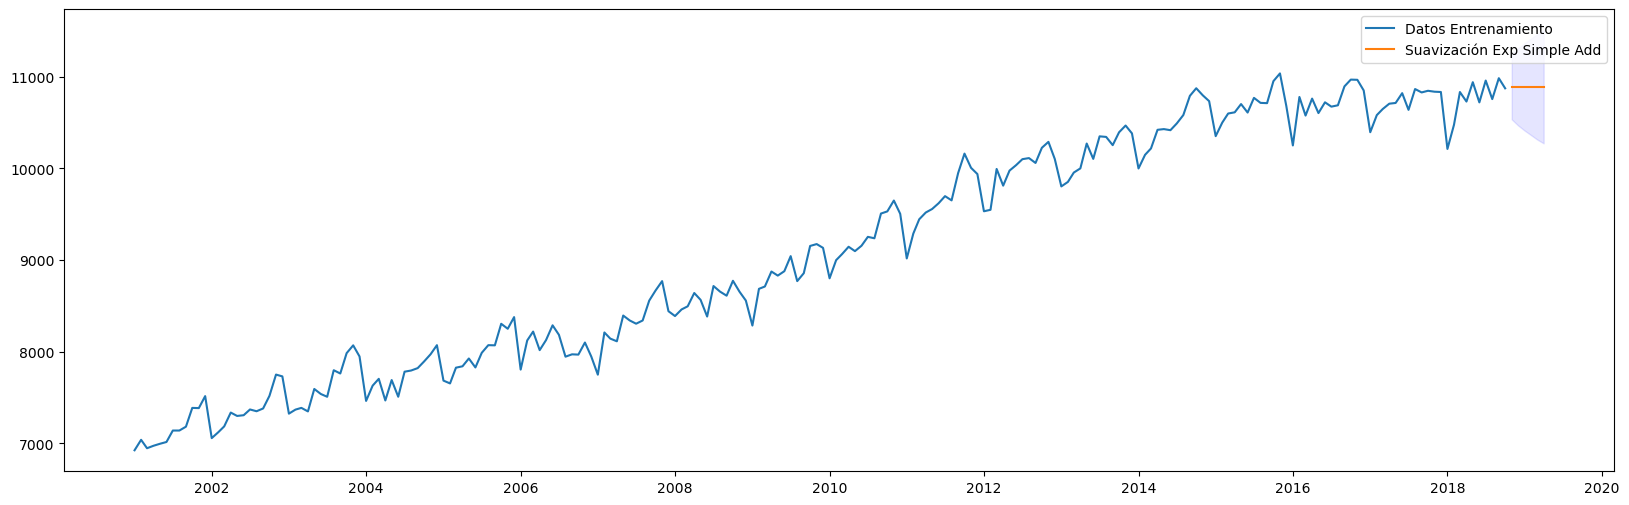

In [45]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="add")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exp Simple Add")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10921.837424  10568.380806  11275.294042
2018-12-01    10940.275438  10532.004006  11348.546870
2019-01-01    10958.713453  10501.184714  11416.242191
2019-02-01    10977.151467  10474.277743  11480.025190
2019-03-01    10995.589481  10450.297525  11540.881437
2019-04-01    11014.027495  10428.599445  11599.455545


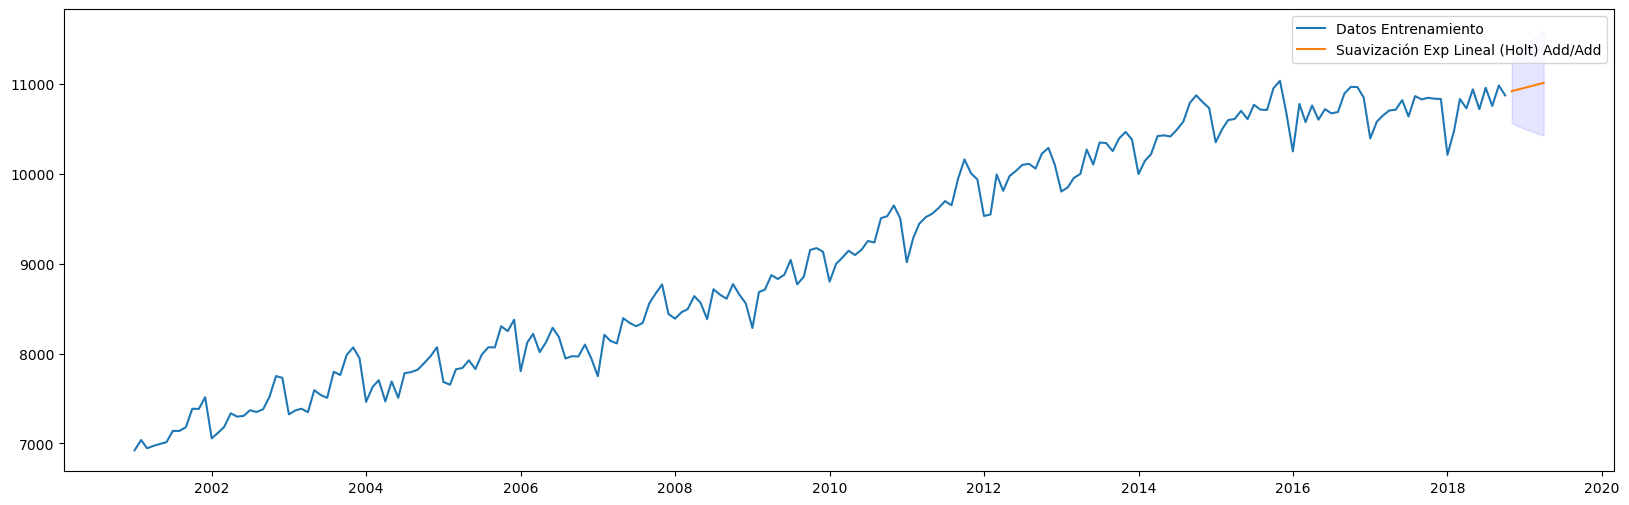

In [46]:


ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend="add")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exp Lineal (Holt) Add/Add")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10939.334909  10669.755783  11208.914036
2018-12-01    10809.530631  10511.327925  11107.733337
2019-01-01    10305.721961   9981.412229  10630.031694
2019-02-01    10576.608995  10228.142711  10925.075279
2019-03-01    10710.727679  10339.674179  11081.781178
2019-04-01    10708.174186  10315.831672  11100.516699


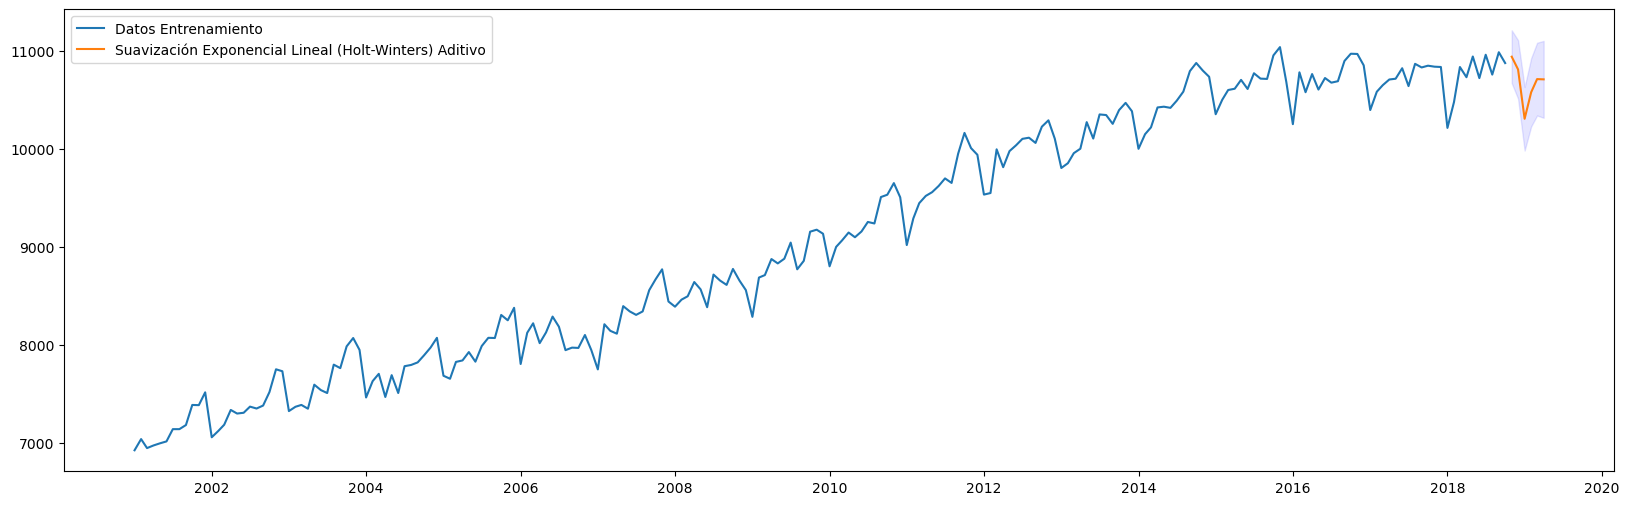

In [47]:
# Build model
ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend=None,seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

## **CONCLUSION**

Con esto, el mejor modelo es **Suavizacion Exponencial Lineal de Winters** (**Holt-Winters**), con parametros Error : **Aditivo**, Tendencia : **None**, Estacionalidad : **Aditivo**,

Error RMSE = 74.995 y Coef R2 = 0.8183 por tanto haremos predicciones con este modelo.

## **Pronóstico | Figura** [Datos Completos]

C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2019-05-01    10706.906928  10450.342687  10963.471169
2019-06-01    10651.859006  10357.112420  10946.605593
2019-07-01    10713.089838  10384.569077  11041.610599
2019-08-01    10689.491216  10330.358607  11048.623825
2019-09-01    10766.753884  10379.421248  11154.086521
2019-10-01    10826.874278  10413.259830  11240.488726


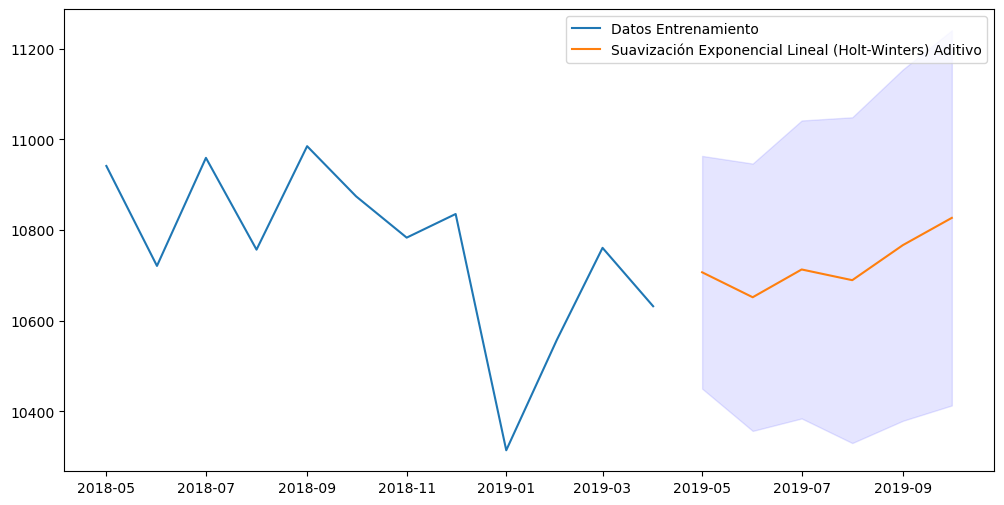

In [48]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/datosEmpleo.xlsx?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_excel(url,index_col='mes',parse_dates=True)
data.head()

# Build model
ets_model = ETSModel(endog=data["Ocupados"],error="add",trend=None,seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

fig = plt.figure(figsize=(12, 6))
plt.plot(data["Ocupados"][208:],label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()